W tym notatniku przedstawiony zostanie koncept autoenkoderów. Bazuje głównie na książce "*Deep learning*", Ian Goodfellow.

# Ogólna idea autoenkoderów

**Autoenkoder** to sieć neuronowa, której zadaniem jest próba skopiowania wejścia sieci. Zawiera warstwę ukrytą, która opisuje **kod** użyty do reprezentowania wejścia sieci.

Generalnie struktura autoenkoderów jest dwuczęściowa:
- blok enkodera, który przetwarza wejście sieci do wspomnianego kodu
- blok dekodera, który stara się odtworzyć wejście sieci na podstawie kodu

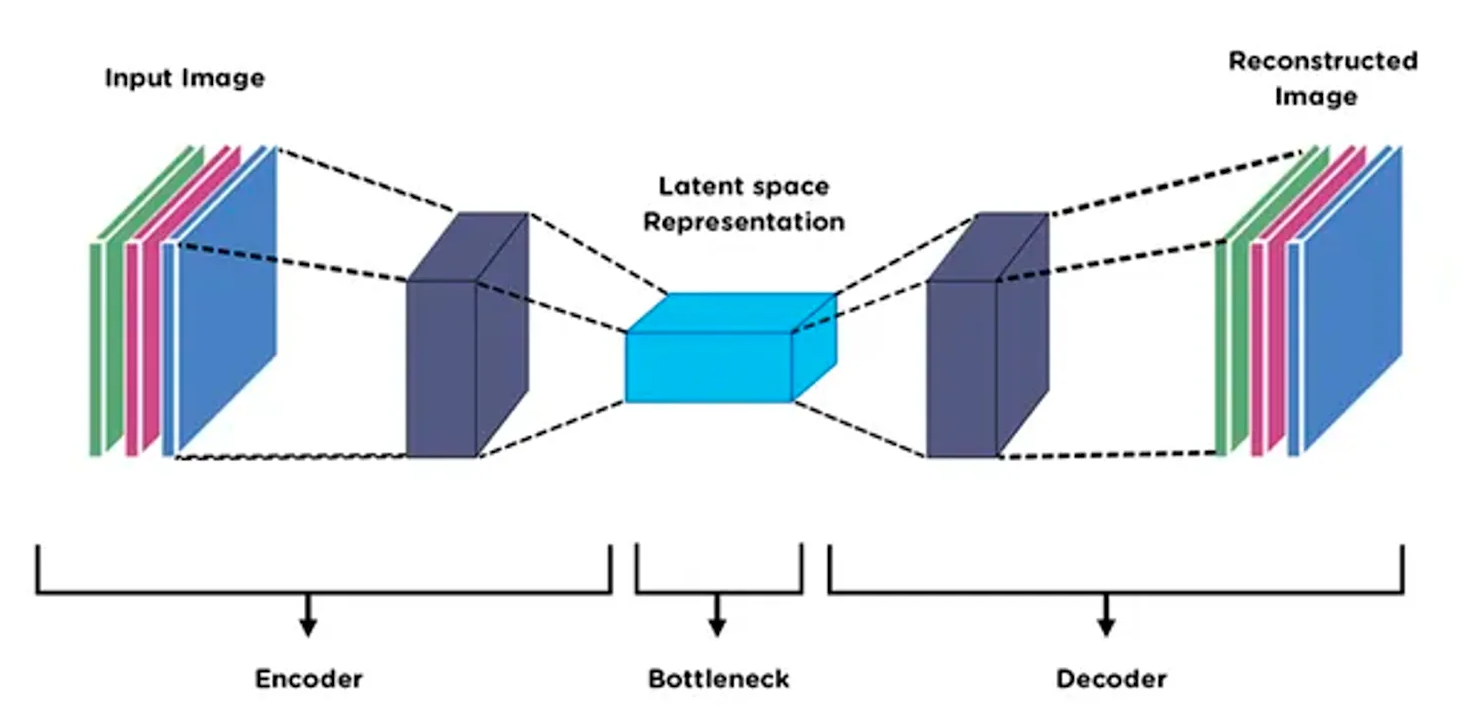

Jednak samo kopiowanie wydaje się raczej nudnym zadaniem... Dlatego **nie chcemy, aby autoenkodery dokładnie odtwarzały wejście**, a jedynie w pewnym przybliżeniu. Zazwyczaj są w jakiś sposób ograniczone, co uniemożliwia im dokonanie idealnej kopii. Dzięki temu w procesie treningu autoenkoder musi działać z ograniczonymi zasobami, przez co **jest zmuszony priorytetyzować informacje** zapisywane w procesie enkodowania. Często w ten sposób sieć uczy się istotnych właściwości danych.

Warto zwrócić uwagę, że mamy tutaj doczynienia z uczeniem nienadzorowanym. To oznacza, że jeżeli powyższy zamysł się sprawdzi, autoenkodery mogą służyć do automatycznego rozpoznawania istotnych cech danych treningowych.

Wspomnianego wyżej ograniczania zasobów można dokonać na wiele sposobów, co skutkuje wieloma rodzajami autoenkoderów. Najbardziej intuicyjnym sposobem wydaje się ustanowienie takiego kodu, który ma mniej wymiarów niż wejście sieci.


# Undercomplete autoencoder

Autoenkoder, którego kod jest mniejszy niż samo wejście, określany jest jako undercomplete. Próba wytworzenia reprezentacji mniejszej niż samo wejście sprawia, że **autoenkoder musi uchwycić wyłącznie najważniejsze cechy** rozpatrywanych danych.

Proces uczenia takiej sieci jest bardzo prosty - wystarczy minimalizować funkcję straty, która polega na różnicy między wejściem a wyjściem.
Aby zademonstrować tą prostotę stwórzmy bardzo prosty undercomplete autoencoder. Jako wejścia będziemy używać cyfr ze znanego i lubianego zbioru MNIST. 

Zazwyczaj do "walki" z obrazami, a w szczególności do ich generacji, używa się warstw konwolucyjnych. Tutaj, ponieważ i tak mamy tylko 1 kanał kolorów (czarno-biały) zastosujemy zwykłe linear, aby zachować prostotę przykładu.

Value range after normalization: (-1.0, 1.0)


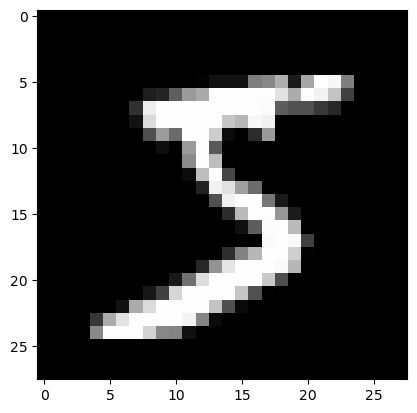

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from typing_extensions import NamedTuple

dataset = MNIST(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]), download=True)
should_pin_memory = torch.cuda.is_available()
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, pin_memory=should_pin_memory)
first_sample = dataset[0][0]
plt.imshow(first_sample.squeeze(0), cmap='gray')
print(f"Value range after normalization: {(first_sample.min().item(), first_sample.max().item())}")


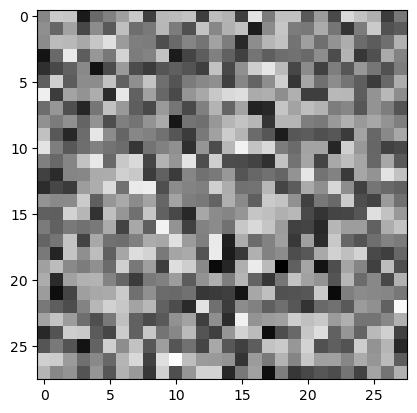

In [2]:
code_dim = 5
class MNIST_autoencoder(nn.Module):
    def __init__(self):
        super(MNIST_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(12),
            nn.ReLU(),
            nn.LazyLinear(code_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, 12),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(784),
            nn.Tanh(), # stosujemy Tanh, ponieważ po normalizacji input jest w zakresie (-1;+1)
        )
        
    def forward(self, x):
        # trzeba dodać wymiar batcha sztucznie jeżeli go nie ma
        if x.ndim == 2:
            x = x.unsqueeze(0)
        x = torch.flatten(x, start_dim=1)
        x = self.decoder(self.encoder(x))
        return x.view(-1, 28, 28)
    
m = MNIST_autoencoder()
plt.imshow(m(first_sample).detach().squeeze(0).squeeze(0), cmap='gray')

In [3]:
EPOCHS = 10
LEARNING_RATE = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
m = m.to(device)
for epoch in range(EPOCHS):
    curr_loss = 0.
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for (x, _) in dataloader:  # niepotrzebny nam label - uczenie nienadzorowane
        x = x.view(-1, 28, 28)
        x = x.to(device)
        output = m(x)
        loss = loss_fn(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
    print(curr_loss)
        


Using device: cuda
Epoch 1/10
0.1789616197347641
Epoch 2/10
0.13517378270626068
Epoch 3/10
0.12791846692562103
Epoch 4/10
0.12348929792642593
Epoch 5/10
0.12665818631649017
Epoch 6/10
0.1116308644413948
Epoch 7/10
0.12317805737257004
Epoch 8/10
0.10656169801950455
Epoch 9/10
0.10172629356384277
Epoch 10/10
0.11334647983312607


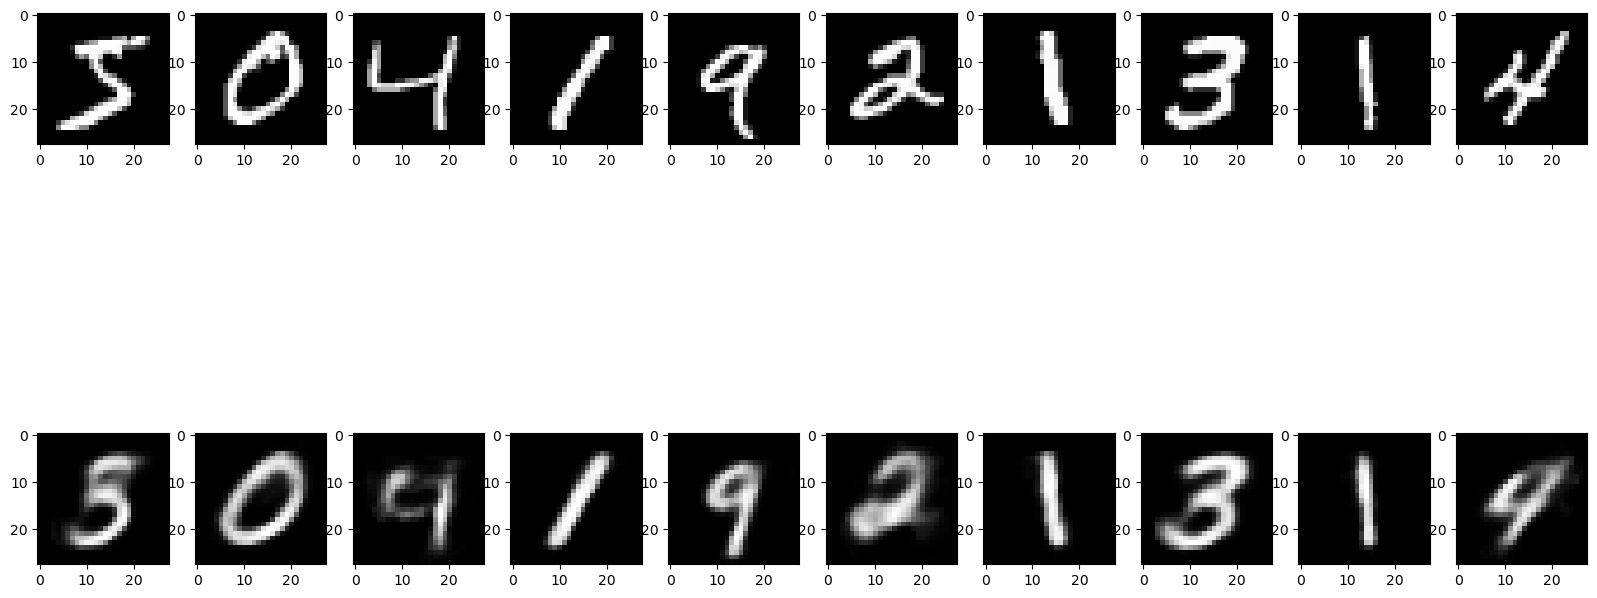

In [4]:
_, axs = plt.subplots(2, 10, figsize=(20, 10))
for i in range(10):
    img = dataset[i][0]
    axs[0][i].imshow(img.squeeze(), cmap='gray')
    output = m(img.cuda()).squeeze()
    axs[1][i].imshow(output.detach().cpu(), cmap='gray')


Jak widać, nasz autoenkoder "jakoś" sobie poradził... Jednak nie można powiedzieć, że jest idealny. 5 zamienił na 3, 4 na 9... Niemniej nie można mu odmówić tego, że większość cyfr jest prawidłowa, nawet jeśli nieco rozmyta. 

Należy pamiętać, że w procesie treningu te obrazY zostały zredukowane z 784 wymiarów do zaledwie kilku, i z tych kilku odtworzone z powrotem. To sugeruje, że nasz autoenkoder był w stanie faktycznie nauczyć się istostnych cech tych obrazków, skoro wiele z nich jest w stanie odtworzyć z powrotem. **Należy pamiętać, że nie wiemy, czego on się nauczył!**. Może rozpoznaje cyfry (chociaż to wątpliwe, w końcu nie kazaliśmy mu klasyfikować cyfr), może rozpoznaje poszczególne kształty... nie wiadomo.

W zależności od liczby wymiarów użytego kodu, nasz autoenkoder radził sobie lepiej lub gorzej. Dla 10 wymiarów, prawie wszystkie cyfry zostały poprawnie odtworzone. Jednak niestety nie mamy możliwości dowiedzieć się, czy nasz autoenkoder nauczył się czegoś istotnego na temat tych danych, czy już miał wystarczająco mocy, aby je po prostu przekopiować.

Sprawdźmy teraz, jak nasz prosty system zareaguje, gdy dodamy nieco szumu:

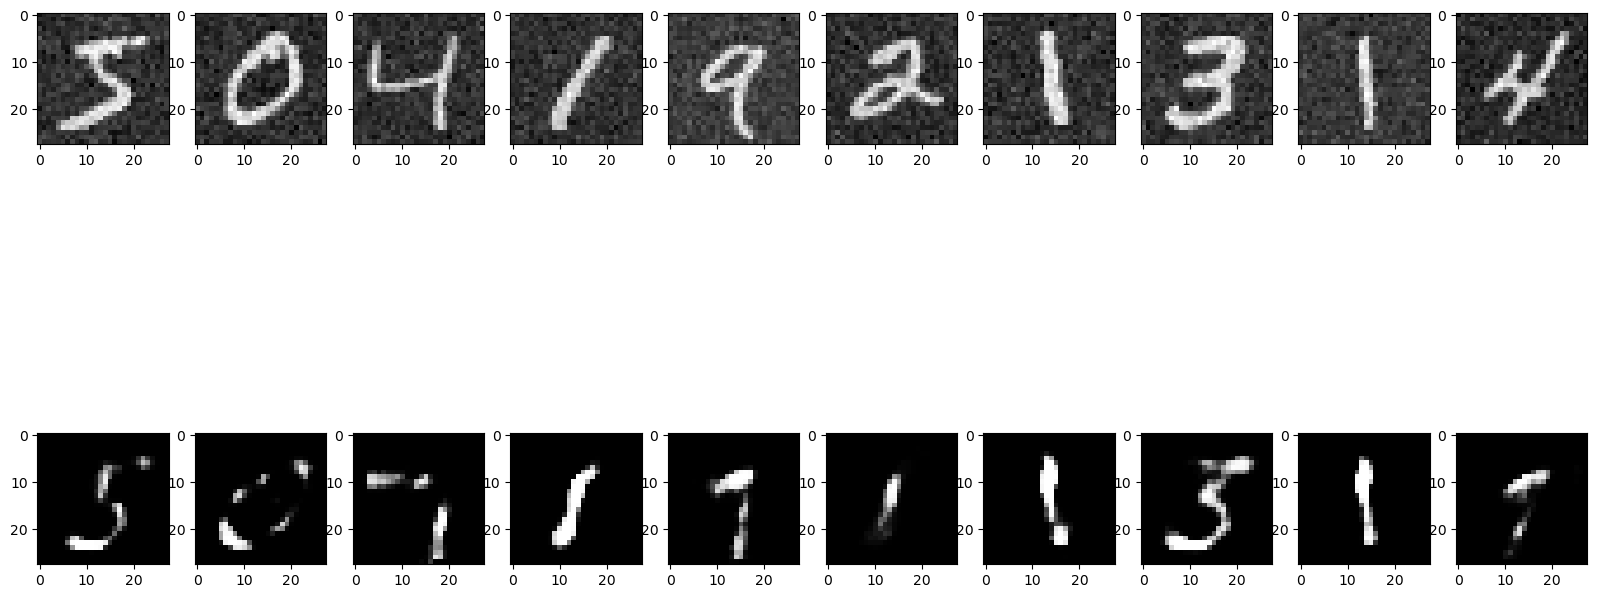

In [5]:
from torchvision.transforms.v2 import GaussianNoise
NOISE_MEAN = 0.0
NOISE_SIGMA = 0.35
noise_transform = torchvision.transforms.Compose([
        transforms.Normalize(0.5, 0.5),
        GaussianNoise(mean=NOISE_MEAN, sigma=NOISE_SIGMA, clip=False),
])
_, axs = plt.subplots(2, 10, figsize=(20,10))
for i in range(10):
    img = dataset[i][0]
    axs[0][i].imshow(noise_transform(img).squeeze(), cmap='gray')
    output = m(noise_transform(img).cuda()).squeeze()
    axs[1][i].imshow(output.detach().cpu(), cmap='gray')

Jak widać, w większości cyfr nadal poradził sobie zaskakująco dobrze. Oczywiście, nie jest tak dobrze jak bez szumów, jednak udało mu się odtworzyć coś, co nawet wygląda jak cyfry... I to mimo tego, że poziom zaszumienia obrazów jest istotny.
I to w dodatku zrobił to korzystając ze zwykłych warstw Linear, bez warstw konwolucyjnych, które zazwyczaj są używane do przetwarzania obrazów.

Owszem, nasze zadanie było bardzo proste (nieduże obrazy, bez żadnego tła, jeden kanał kolorów), jednak mimo to uzyskanie "odszumiacza" obrazów o tak prostej konstrukcji jest zaskakujące, a na pewno dla mnie było :)

**Undercomplete autoencoder, mimo swoich zalet, ma pewną wadę**, na którą uwagę w swojej książce zwracał Ian Goodfellow. 
> **Samo ograniczenie wymiaru kodu nie wystarczy, aby taki model uczył się ważnych cech!** 
> Dlaczego? Ponieważ nawet przy kodzie zawierającym zaledwie 1 wymiar, jeżeli encoder i decoder będą wystarczająco mocne, nasz model i tak będzie w stanie po prostu dokonać kopii. **Każdy przykład ze zbioru treningowego zakoduje jako unikalną liczbę *i*, którą odpowiednio mocny decoder będzie w stanie odtworzyć do oryginalnego wejścia**. Jest to oczywiście niepożądane, ponieważ zazwyczaj taki kod nie ma dla nas żadnej wartości.

**To oznacza, że undercomplete autoencoder jest bardzo nieelastyczną konstrukcją** - trzeba balansować na krawędzi ostrza: zbyt słaba sieć nic się nie nauczy, ale zbyt mocna też... Jest to oczywiście prawdą dla każdej sieci neuronowej, jednak w przypadku undercomplete autoencoderów jest to bardzo silnie widoczne.

Co w takiej sytuacji zrobić, jeżeli z jakiegokolwiek powodu chcemy zastosować "silniejszą" sieć? Zastanawiamy się. Wspomniany wyżej proces bardzo przypomina overfitting. Jak sobie z nim radzono już od bardzo dawna? Korzystając z regularyzacji.

# Regularized autoencoders

Metod regularyzowania autoencoderów jest wiele, i mogą przyjmować naprawdę różne formy. Można wymagać określonych właściwości od kodu, np. żeby był (lub nie był) odpowiednio różniczkowalny, żeby był rzadki (sparse) lub odwrotnie (dense). Można także wymagać odpowiednich właściwości od samej sieci - ćwicząc ją z zaszumionymi obrazami, czy zmuszając do "walki" z brakującymi inputami.

Metoda regularyzacji autoenkodera jest tak naprawdę dowolna, tak długo, jak długo powstrzymuje autoenkoder przed nauczeniem się funkcji tożsamościowej.

Skoro już (przypadkiem) odkryliśmy, że autoenkoder może dobrze odszumiać obrazy, pociągnijmy to nieco dalej.

## Denoising autoencoder

Istnieją oczywiście autoencodery przeznaczone specjalnie do walki z zaszumionymi danymi.
Metoda ich treningu jest dość prosta i niewiele różni się od undercomplete autoencoders - po prostu jako input takiego encodera podajemy zaszumione dane, a oczekujemy, że odtworzy nam dane oryginalne, bez szumu. Na razie wypróbujmy naszą architekturę na takiej metodzie treningu. 

In [6]:
m = MNIST_autoencoder()

EPOCHS = 10
LEARNING_RATE = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
m = m.to(device)
for epoch in range(EPOCHS):
    curr_loss = 0.
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for (x, _) in dataloader:  # niepotrzebny nam label - uczenie nienadzorowane
        x = x.view(-1, 28, 28)
        x = x.to(device)
        x_with_noise = noise_transform(x)
        output = m(x_with_noise).squeeze()
        loss = loss_fn(output, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
    print(curr_loss)

Using device: cuda
Epoch 1/10
0.21715335547924042
Epoch 2/10
0.18416373431682587
Epoch 3/10
0.1883036196231842
Epoch 4/10
0.15112103521823883
Epoch 5/10
0.14596852660179138
Epoch 6/10
0.1428527981042862
Epoch 7/10
0.16816507279872894
Epoch 8/10
0.14043813943862915
Epoch 9/10
0.1511315107345581
Epoch 10/10
0.13019220530986786


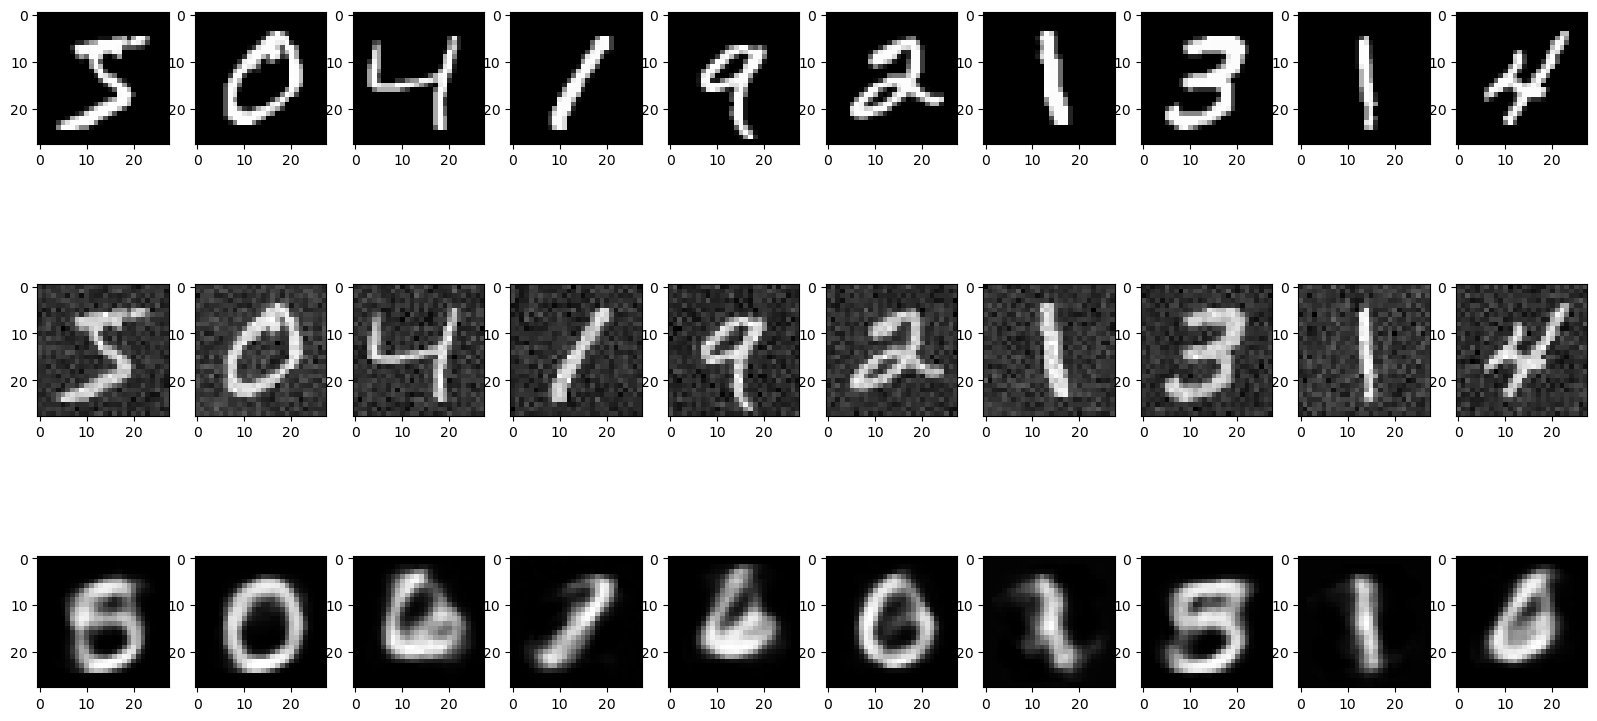

In [7]:
_, axs = plt.subplots(3, 10, figsize=(20,10))
for i in range(10):
    img = dataset[i][0]
    axs[0][i].imshow(img.squeeze(), cmap='gray')
    output = m(img.cuda()).squeeze()
    axs[1][i].imshow(noise_transform(img).squeeze(), cmap='gray')
    axs[2][i].imshow(output.detach().cpu(), cmap='gray')
    

Wygląda na to, że nasz model wcale nie radzi sobie lepiej? Możliwe, jednak dzięki zastosowaniu regularyzacji, możemy spróbować ten model powiększyć, nie ryzykując przy tym, że będzie tworzył idealne kopie. 

Można też w tym momencie stwierdzić, że nasze uczenie przestaje być nienadzorowane - ponieważ mamy pary: dane uczące (zaszumiony x) oraz oczekiwany obraz (oryginalny x).

W związku z tym podzielmy nasz zbiór na część treningową i testową. Pozwoli nam to sprawdzić, czy powiększanie naszego modelu nie prowadzi do overfittingu.

Zwiększymy także siłę szumu, aby dać większemu modelowi możliwość wykazania się. *Informacja z przyszłości - po odrobinie eksperymentowania okazało się, że model jest w stanie dość dobrze sobie radzić z szumem o sigmie pomiędzy 0.6 a 0.7*.



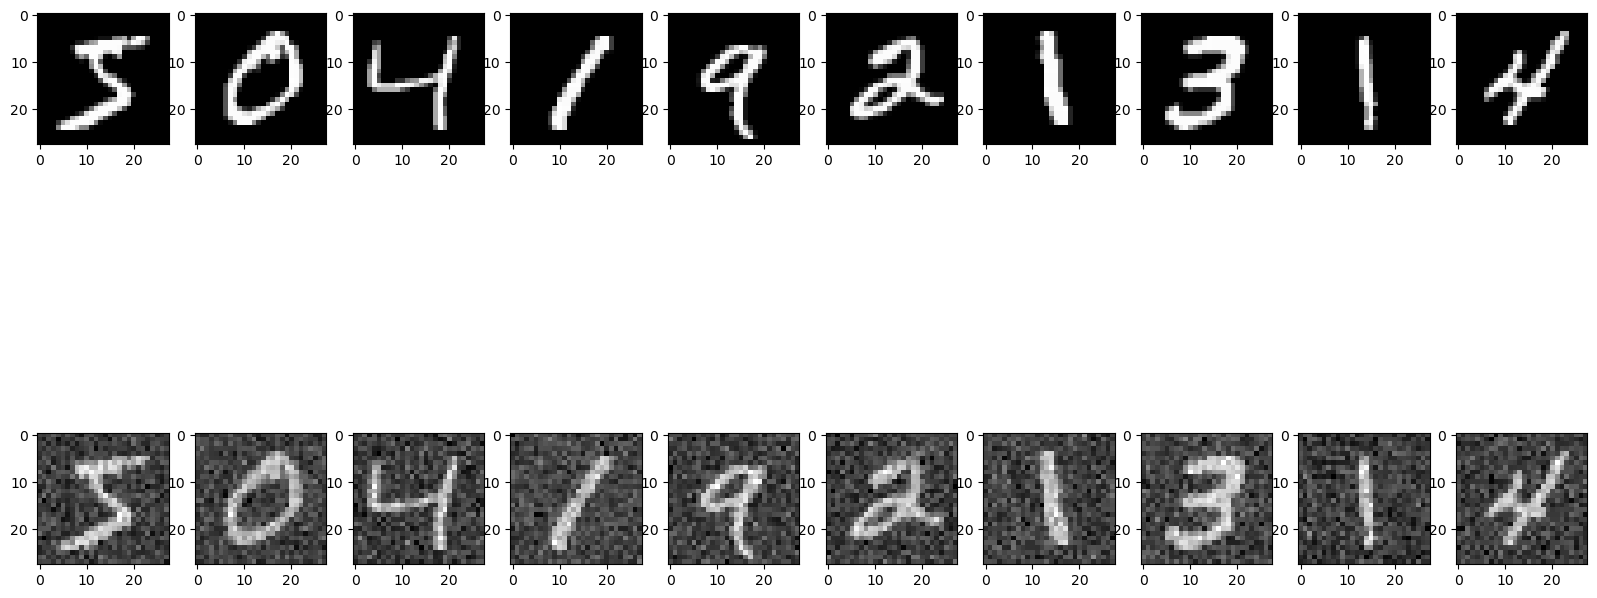

In [8]:
NOISE_MEAN = 0.0
NOISE_SIGMA = 0.65
noise_transform = torchvision.transforms.Compose([
        transforms.Normalize(0.5, 0.5),
        GaussianNoise(mean=NOISE_MEAN, sigma=NOISE_SIGMA, clip=False),
])
_, axs = plt.subplots(2, 10, figsize=(20,10))
for i in range(10):
    img = dataset[i][0]
    axs[0][i].imshow(img.squeeze(), cmap='gray')
    axs[1][i].imshow(noise_transform(img).squeeze(), cmap='gray')

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_subset, batch_size=64, pin_memory=should_pin_memory, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, pin_memory=should_pin_memory, shuffle=True)

In [10]:
from collections import namedtuple
ParamsForAutoencoder = namedtuple("ParamsForAutoencoder", " layer1 layer2 layer3 codedim")

In [11]:
class bigger_MNIST_autoencoder(nn.Module):
    def __init__(self, params: ParamsForAutoencoder):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, params.layer1),
            nn.ReLU(),
            nn.LazyLinear(params.layer2),
            nn.ReLU(),
            nn.LazyLinear(params.layer3),
            nn.ReLU(),
            nn.LazyLinear(params.codedim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(params.codedim, params.layer3),
            nn.ReLU(),
            nn.LazyLinear(params.layer2),
            nn.ReLU(),
            nn.LazyLinear(params.layer1),
            nn.ReLU(),
            nn.LazyLinear(784),
            nn.Tanh(), # stosujemy Tanh, ponieważ po normalizacji input jest w zakresie (-1;+1)
        )
        
    def forward(self, x):
        # trzeba dodać wymiar batcha sztucznie jeżeli go nie ma
        if x.ndim == 2:
            x = x.unsqueeze(0)
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x)
        x = self.decoder(encoded)
        return x.view(-1, 28, 28)
    

In [12]:
params1 = ParamsForAutoencoder(384, 196, 64, 15)
m = bigger_MNIST_autoencoder(params1)
m = m.to(device)

In [13]:
def training_loop(model: nn.Module, optimizer, train_loader: DataLoader, EPOCHS: int=10, test_loader=None, noise=True):
    for epoch in range(EPOCHS):
        losses = torch.empty(size=[len(train_loader)], device=device)
        i = 0
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        for (x, _) in train_loader:
            x = x.view(-1, 28, 28)
            x = x.to(device)
            if noise is True:
                x_with_noise = noise_transform(x)
                output = model(x_with_noise).squeeze()
            else:
                output = model(x).squeeze()
            loss = loss_fn(output, x)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses[i] = loss.item()
            i += 1
        print(f"Mean loss for epoch (train data): {losses.mean().item()}")
        if test_loader is None:
            continue
        losses = torch.empty(size=[len(test_loader)], device=device)
        i = 0
        for (x, _) in test_loader:
            with torch.inference_mode():
                x = x.view(-1, 28, 28)
                x = x.to(device)
                if noise is True:
                    x_with_noise = noise_transform(x)
                    output = model(x_with_noise).squeeze()
                else:
                    output = model(x).squeeze()
                loss = loss_fn(output, x)
                losses[i] = loss.item()
                i += 1
        print(f"Mean loss for epoch (test data): {losses.mean().item()}")
optim = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  

In [14]:
training_loop(m, optim, train_loader, 10, test_loader)

Epoch 1/10
Mean loss for epoch (train data): 0.27392980456352234
Mean loss for epoch (test data): 0.23043400049209595
Epoch 2/10
Mean loss for epoch (train data): 0.16552896797657013
Mean loss for epoch (test data): 0.13279883563518524
Epoch 3/10
Mean loss for epoch (train data): 0.12375273555517197
Mean loss for epoch (test data): 0.11583329737186432
Epoch 4/10
Mean loss for epoch (train data): 0.10947975516319275
Mean loss for epoch (test data): 0.10468846559524536
Epoch 5/10
Mean loss for epoch (train data): 0.10024484992027283
Mean loss for epoch (test data): 0.09705126285552979
Epoch 6/10
Mean loss for epoch (train data): 0.09274034202098846
Mean loss for epoch (test data): 0.09171149134635925
Epoch 7/10
Mean loss for epoch (train data): 0.08810503780841827
Mean loss for epoch (test data): 0.08679419755935669
Epoch 8/10
Mean loss for epoch (train data): 0.0844147652387619
Mean loss for epoch (test data): 0.08482344448566437
Epoch 9/10
Mean loss for epoch (train data): 0.0818243697

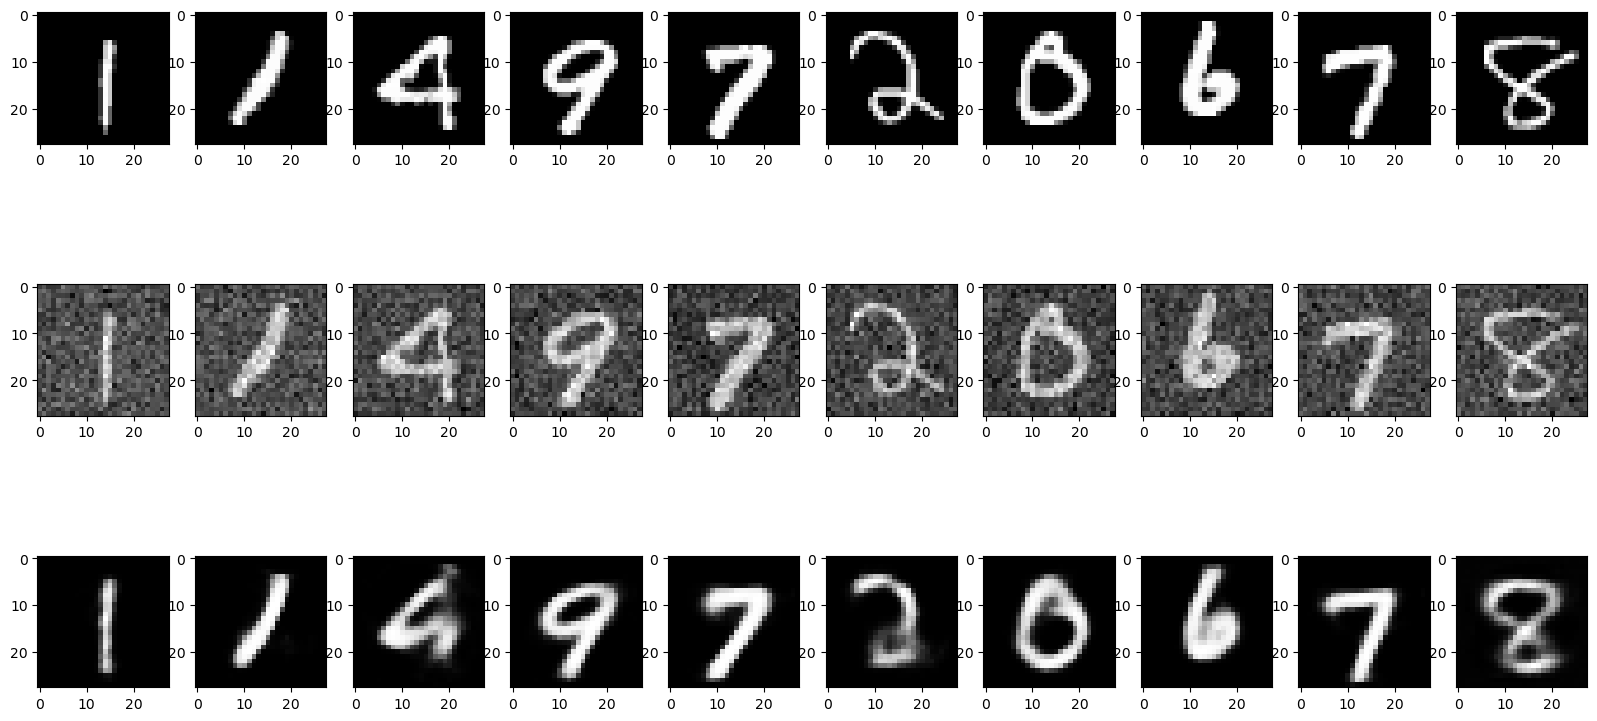

In [15]:
import time


def check_example_images(model: nn.Module, dataset, randomize=True, seed=42, noise=True):
    model.eval()
    seed = seed if randomize is not True else int(time.time())
    torch.manual_seed(seed)
    indexes = torch.randint(len(dataset), size=(10,),)
    torch.manual_seed(int(time.time()))
    if noise is True:
        _, axs = plt.subplots(3, 10, figsize=(20,10))
        for i, idx in enumerate(indexes):
            img = dataset[idx][0]
            noisy_img = noise_transform(img)
            axs[0][i].imshow(img.squeeze(), cmap='gray')
            axs[1][i].imshow(noisy_img.squeeze(), cmap='gray')
            axs[2][i].imshow(model(noisy_img.to(device)).squeeze().detach().cpu(), cmap='gray')
        return 
    _, axs = plt.subplots(2, 10, figsize=(20,10))
    for i, idx in enumerate(indexes):
        img = dataset[idx][0]
        axs[0][i].imshow(img.squeeze(), cmap='gray')
        axs[1][i].imshow(model(img.to(device)).squeeze().detach().cpu(), cmap='gray')
        model.train()
check_example_images(m, test_subset)

Jak widać nasz denoising autoencoder poradził sobie bardzo dobrze. Za jego pomocą byliśmy w stanie uporać się z dużo silniejszym szumem, niż z wykorzystaniem pierwszego autoenkodera. Zdecydowaną większość cyfr odszumia poprawnie. Nie tylko rozpoznaje te cyfry, ale także jest w stanie zachować część informacji o ich strukturze, jak na przykład pochylenie czy odstające od normy krawędzie. Oczywiście nie wszystkie, więc cyfry nie są odwzorowywane dokładnie. To, jak wiele informacji jest finalnie zawartych, zależy między innymi od rozmiaru warstwy z kodem.

## Contractive autoencoder

Pokazaliśmy już autoenkodery, w których ograniczeniem przed kopiowaniem danych był:
 - rozmiar wewnętrznej reprezentacji danych (undercomplete)
 - szum obecny w danych (denoising)

Jest jeszcze trzeci deterministyczny (VAE jest probalistyczny i przedstawię go później) rodzaj autoenkodera warty przedstawienia  - Contractive autoencoder.

**Jego ograniczenie polega na tym, że do funkcji straty dodajemy dodatkowe wyrażenie oparte o Jakobian (macierz 1. pochodnych) kodu**. Dodajemy podniesioną do kwadratu normę Frobeniusa, czyli de facto sumę kwadratów wszystkich elementów w macierzy Jakobianu, jak przedstawione poniższym wzorem:
$$||J_h(X)||_F^2 = \sum_{ij} \left( \frac{\partial h_j(X)}{\partial X_i} \right)^2 $$

Wtedy funkcja straty takiego modelu wygląda następująco:
$$ L = MSE(x, r(x)) + \lambda ||J_h(X)||^2_F $$

To oznacza, że model będzie starał się minimalizować pochodne wewnątrz przestrzenii reprezentacji danych. **Ma to skutkować tym, że pewne sądziedztwo punktu `x` (czyli danych wejściowych) po przekształceniu do wewnętrznej reprezentacji h znajdzie się w mniejszym sąsiedztwie - stąd nazwa contractive**. Ta własność wynika właśnie z prób minimalizowania elementów składowych Jakobianu - będzie się tak działo, gdy elementy w tym Jakobianie (czyli poszczególne pochodne cząstkowe) będą mniejsze niż 1. Zazwyczaj przy ćwiczeniu takich enkoderów ten efekt jest osiągany przynajmniej w większości kierunków. **Powoduje to, że niewielkie zmiany (np. szum) na wejściu `x` powodują mniejsze zmiany na wyjściu.**

Dla klarowności, ta właściwość ma działać tylko lokalnie - dla najbliższego sąsiedztwa punktu `x`. Różne od siebie punkty `x` oraz `x'` mogą (a wręcz powinny) nie znajdować się w bezpośrednim sąsiedztwie w przestrzenii wewnętrznej reprezentacji.

Na szczęście żyjemy w 2025 roku i nie musimy umieć policzyć Jakobianu ręcznie - PyTorch ma to wbudowane :) 

*Informacja z przyszłości - obliczanie tego Jakobianu jest **bardzo** powolne... Dlatego trzeba pokombinować z jego estymacjami.
Możemy wykorzystać fakt, że nie jest nam potrzebny faktycznie cały Jakobian, a jedynie jego norma Frobeniusa. Jest to dość częsty problem, więc wymyślono techniki aproksymowania tej normy, które powinny być rzędy wielkości szybsze.*

### Estymacja normy Frobeniusa Jakobianu metodą przybliżenia Hutchinsona

Wszystkie niezbędne informacje do zgłębienia tego tematu są w poniższych materiałach:
- https://en.wikipedia.org/wiki/Trace_(linear_algebra)
- https://www.mathsisfun.com/algebra/matrix-multiplying.html
- **[A stochastic estimator of a trace of a matrix - Hutchinson, M. F. (1989)](https://www.researchgate.net/publication/245083270_A_stochastic_estimator_of_the_trace_of_the_influence_matrix_for_Laplacian_smoothing_splines)**

Przedstawiając to w skrócie: interesuje nas suma kwadratów wszystkich elementów tego Jakobianu. Klasyczna właściwość algebry liniowej, wynikająca z definicji mnożenia macierzowego, mówi, że można to wyrazić jako sumę elementów na przekątnej (tzw. ślad) macierzy $J \times J^T$.

Wyznaczenie śladu macierzy nie wymaga szacowania wszystkich jej elementów - korzystamy z **estymatora śladu Hutchinsona**. Oryginalny Paper jest dość obszerny i zawiły - nas interesuje z niego tylko sama technika przybliżania śladu macierzy:
- musimy wybrać taki wektor v, aby wartością oczekiwaną mnożenia macierzowego (traktujemy vektory jak macierze) $v \times v^T$była macierz jednostkowa $\mathbb{I}$. Najczęściej wybierane są wektory losowane z rozkładu Rademachera (każdy element ma wartość 1 lub -1) lub z rozkładu normalnego N(0;1)
- jeżeli $\mathbb{E}(v \times v^T) = \mathbb{I}$, to można wykazać, że dla każdej macierzy kwadratowej $\mathbb{A}$ zachodzi wzór: $$\mathbb{E}(v^T \times \mathbb{A} \times v) = tr(\mathbb{A}) $$
- skoro wartością oczekiwaną tego mnożenia jest ślad macierzy $\mathbb{A}$, to uśredniając wyniki wielu takich mnożeń spodziewamy się otrzymać ślad macierzy $\mathbb{A}$
 

W tym momencie osiągnęliśmy tyle, że spodziewamy się, że: 
$$\mathbb{E}(v^T(JJ^T)v) = ||J||^2_F$$

Pozornie niewiele nam to dało, przecież w tym wzorze nadal mamy Jakobian J, którego przecież nie chcemy liczyć...
Tutaj z pomocą przychodzi nam powiązanie tego z wyrażeniem **Vector-Jacobian Product**. Przekształcając nieco poprzedni wzór uzyskujemy:
$$ v^T(JJ^T)v = (J^Tv)^T(J^Tv) = ||J^Tv||^2_2 $$ a więc $$\mathbb{E}(||J^Tv||^2_2) = ||J||^2_F $$

No dobra, ale w czym to nam pomogło? Nadal mamy w tym wzorze J, tyle że transponowane... Pomaga nam to w taki sposób, że korzystamy z PyTorch, który ma wbudowany autograd. **Autograd, który daje nam możliwość obliczenia iloczynu $J^Tv$ bez wyznaczania wszystkich elementów całego Jakobianu**. I jesteśmy w domu :)

W nowszych wersjach PyTorcha jest to wbudowane - oszczędza to nieco pisaniny.

**Należy pamiętać, że korzystamy tutaj z estymacji - jej dokładność będzie tym lepsza, im więcej przeprowadzimy mnożeń $J^Tv$ z wykorzystaniem różnych, niezależnych od siebie, wektorów v**.
W jaki sposób ustalić, ile razy przeprowadzić pobór próbki do estymatora Hutchinsona? Eksperymentalnie :) Jest to estymator nieobciążony, i wraz ze zwiększaniem liczby próbek zmniejsza się jego wariancja. Wielu badaczy stwierdza, że już 20 próbek daje satysfakcjonujące wyniki - my sprawdzimy kilka różnych progów i zobaczymy, w którym wariancja (a raczej odchylenie standardowe) nie będzie "zbyt duża" .
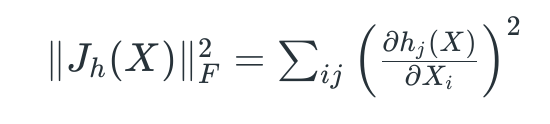

In [16]:
class contractive_MNIST_autoencoder(nn.Module):
    def __init__(self, layer_size, code_dim, dropout=0.15):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, layer_size),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(layer_size, code_dim),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, layer_size),
            nn.Dropout(p=dropout*2/3),
            nn.ReLU(),
            nn.Linear(layer_size, 784),
            nn.Tanh()
        )
        self.layer_size = layer_size

    def encode(self, x):
        """Helper function, so that the JVP can be calculated easily using beloved PyTorch autograd :)"""
        return self.encoder(x)

    @staticmethod
    def calc_frobenius_norm(function, x, how_many_samples, device="cpu") -> torch.Tensor:
        """
        this function calculates the Frobenius norm of the jacobian of given function for given input x.
        Does not calculate the Jacobians directly (I tried, it's expensive and unnecessary), rather uses Hutchinson's estimator.
        Returns it as a 1-element tensor (so that it's gradient can be tracked)
        """
        total_sum = torch.zeros(size=(1,), device=device)
        batch_size = x.size(0)
        one_sample_size = x.size(1)  
        for _ in range(how_many_samples):
            random_vector = torch.randn(size=(batch_size, one_sample_size), device=device)
            _, batch_of_jvps = torch.func.jvp(function, (x,), (random_vector,))
            batch_of_sq_norms = batch_of_jvps.pow(2).sum(dim=-1, keepdim=True)
            total_sq_norm = batch_of_sq_norms.sum()
            total_sum += total_sq_norm
        return  total_sum / how_many_samples
    
    def calc_frobenius_for_encoder(self, x, how_many_samples=60):
        with torch.enable_grad():
            if x. ndim == 2:
                x = x.unsqueeze(0)
            x = torch.flatten(x, start_dim=1)
            device = next(self.parameters()).device
            return self.calc_frobenius_norm(self.encode, x, how_many_samples, device)
    
    def forward(self, x):
        if x. ndim == 2:
            x = x.unsqueeze(0)
        x = torch.flatten(x, start_dim=1)
        encoded = self.encode(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 28, 28)

In [17]:
# Sprawdźmy wariancję dla różnych wartości pobranych próbek
TRIALS = 1000
ranges = [10, 20, 50]
m = contractive_MNIST_autoencoder(20, 4)
img = dataset[0][0].view(1, 784)
results_tensor = torch.empty(size=(TRIALS,))

for n in ranges:
    for i in range(TRIALS):
        results_tensor[i] = m.calc_frobenius_for_encoder(img, n)
    mean = results_tensor.mean()
    var = results_tensor.std()
    print(f"For {n} samples with {TRIALS} tries, standard dev is {var:.6f}, mean is {mean:.6f}, ratio is {100 * var/mean:.5f}%")


For 10 samples with 1000 tries, standard dev is 0.029519, mean is 0.076755, ratio is 38.45848%
For 20 samples with 1000 tries, standard dev is 0.019748, mean is 0.076709, ratio is 25.74390%
For 50 samples with 1000 tries, standard dev is 0.012955, mean is 0.076331, ratio is 16.97188%


50 próbek daje satysfakcjonujący wynik - stosunek std/średnia wynoszący nieco ponad 10%. To oznacza, że predykcje generalnie znajdują się dość blisko wartości średniej. Wygląda to, jakby około 60 próbek redukowało ten stosunek poniżej 10%.

Najpierw spróbujemy z 60 próbkami żeby zobaczyć, czy nie jest to zbyt wymagające obliczeniowo.  *Informacja z przyszłości - jest wymagające obliczeniowo, ale daje radę. Można zaobserować istotną różnicę w stabilności treningu modeli po zmniejszeniu tej liczby, dlatego ją tak pozostawię. Moja karta graficzna jakoś sobie poradzi*

### Mode collapse

W tym momencie warto wspomnieć o występowaniu takiego zjawiska, jak ***mode collapse***. Wspominam o nim bo oczywiście go doświadczyłem i na początku nie miałem pojęcia co się dzieje :)

Jest to fenomen gdy model, najczęściej generatywny, na przykład GAN (ale nie tylko), nie jest w stanie uchwycić pełnej różnorodności danych. Zamiast tego **wytwarza tylko pewien podzbiór wyjść, niezależnie od zmian w wejściu modelu**. Akurat mój "produkował" same dziewiątki.
Wynika najczęściej z tego, że model szybko się uczy, że mapowanie wszystkich wejść do takiego samego, lub podobnego, wyjścia minimalizuje funkcję straty (w naszym przypadku Jakobian). W ten sposób **odkrywa "trywialne" rozwiązanie, które satysfakcjonuje minimum funkcji straty, ale jednocześnie nie uchwyca jakichkolwiek informacji**.

Rozwiązanie tego problemu w naszym przypadku polega na dwóch działaniach:
- Istotnym zmniejszeniu parametru $\lambda$ - musiałem go zmniejszyć o kilka rzędów wielkości
- Okresie startowym, w którym $\lambda$ jest niewielkie i stopniowo rośnie: zmusza to model do nauczenia się rekonstrukcji przed nałożeniem ograniczeń na Jakobian

In [18]:
def contractive_training_loop(model: contractive_MNIST_autoencoder, optimizer, train_loader: DataLoader, EPOCHS: int=10, test_loader=None, lambda_param = 1e-8, lambda_warmup_time:int = 5):
    """
    :param lambda_param: when combining reconstruction loss and contractive loss, how should the contractive loss be scaled. 
        Setting this too high will result in all outputs looking the same, because the model will prioritize lowering the derivatives in the latent space instead of reconstructing images
    :param lambda_warmup_time: if True, first `lamda_warmup_time` epochs will work with `lambda_param` values increasing gradually from 0 to 
       `lambda_params`. This makes the model learn the reconstructions first, and only then adds additional constraints of minimizing the derivatives.
        That often results in more stable training.
    """
    for epoch in range(EPOCHS):
        effective_lambda_param = lambda_param if epoch >= lambda_warmup_time else (epoch / lambda_warmup_time) * lambda_param
        losses = torch.empty(size=[len(train_loader)], device=device)
        reconstruction_losses = torch.empty_like(losses, device=device)
        frobenius_losses = torch.empty_like(losses, device=device)
        i = 0
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        for (x, _) in train_loader:
            x = x.view(-1, 28, 28)
            x = x.to(device)
            output = model(x).squeeze()
            rec_loss = loss_fn(output, x)
            frobenius_loss = m.calc_frobenius_for_encoder(x)
            loss = rec_loss + frobenius_loss * effective_lambda_param
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses[i] = loss.item()
            reconstruction_losses[i] = rec_loss.item()
            frobenius_losses[i] = frobenius_loss.item() * effective_lambda_param
            i += 1
        print(f"Mean loss for epoch (train data): {losses.mean().item()}")
        print(f"Mean reconstruction loss (train data): {reconstruction_losses.mean().item()}")
        print(f"Mean contractive loss (train data): {frobenius_losses.mean().item()}")
        if test_loader is None:
            continue
        losses = torch.empty(size=[len(test_loader)], device=device)
        i = 0
        for (x, _) in test_loader:
            with torch.inference_mode(): 
                x = x.view(-1, 28, 28)
                x = x.to(device)
                output = model(x).squeeze()
                rec_loss = loss_fn(output, x)
                frobenius_loss = m.calc_frobenius_for_encoder(x)
                loss = rec_loss + frobenius_loss * effective_lambda_param
                losses[i] = loss.item()
                reconstruction_losses[i] = rec_loss.item()
                frobenius_losses[i] = frobenius_loss.item() * effective_lambda_param
                optimizer.zero_grad()
                i += 1
        print(20 * "-")
        print(f"Mean loss for epoch (test data): {losses.mean().item()}")
        print(f"Mean reconstruction loss (test data): {reconstruction_losses.mean().item()}")
        print(f"Mean contractive loss (test data): {frobenius_losses.mean().item()}")

        print(50 * "-")

In [19]:
m = contractive_MNIST_autoencoder(256, 64, dropout=0.01)
m.to(device)
optim = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-6)
contractive_training_loop(m, optim, train_loader, EPOCHS, test_loader, lambda_warmup_time=8, lambda_param=1e-8)

Epoch 1/10
Mean loss for epoch (train data): 0.10514595359563828
Mean reconstruction loss (train data): 0.10514595359563828
Mean contractive loss (train data): 0.0
--------------------
Mean loss for epoch (test data): 0.05640025809407234
Mean reconstruction loss (test data): 0.0693909227848053
Mean contractive loss (test data): 0.0
--------------------------------------------------
Epoch 2/10
Mean loss for epoch (train data): 0.048016808927059174
Mean reconstruction loss (train data): 0.04801193252205849
Mean contractive loss (train data): 4.877595074503915e-06
--------------------
Mean loss for epoch (test data): 0.04272213578224182
Mean reconstruction loss (test data): 0.04529011622071266
Mean contractive loss (test data): 3.7690788303734735e-06
--------------------------------------------------
Epoch 3/10
Mean loss for epoch (train data): 0.039414793252944946
Mean reconstruction loss (train data): 0.03940334916114807
Mean contractive loss (train data): 1.1442899449320976e-05
-------

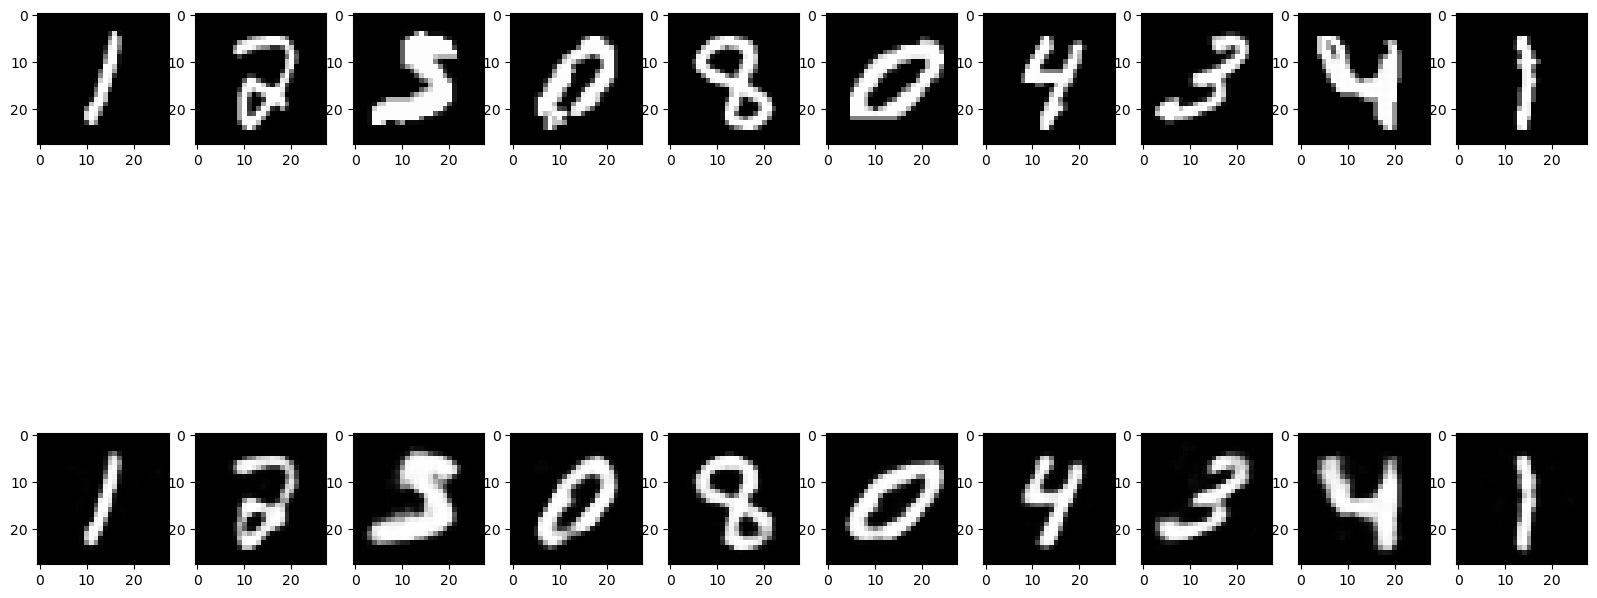

In [21]:
check_example_images(m, test_subset, noise=False)

Po kilku iteracjach zmniejszania parametru $\lambda$ udało się uzyskać porządny model. Wygląda na to, że model działa bez zarzutu. Odwzorowuje cyfry poprawnie i w wysokiej rozdzielczości, nie są tak rozmyte. Owszem, zastosowany został szerszy bottleneck - kod ma 64 wymiary. Niemniej to wciąż oznacza, że nasz autoenkoder jest w stanie tak dokładnie odtwarzać te cyfry z raptem 1/12 oryginalnej informacji! Zwracam uwagę na to, **jak dobrze odwzorowane są szczegóły, takie jak pochylenie, kanciaste/zaokrąglone rogi, czy nawet grubość krawędzi.**

Żeby nie było wątpliwości - to są dane testowe, autoenkoder nigdy wcześniej ich nie widział i się na nich nie uczył.

Oficjalnie ogłaszam sukces - contractive autoencoder faktycznie pozwala na więcej niż zwykły undercomplete autoencoder.

Sprawdźmy jeszcze tylko, w ramach przysłowiowej wisienki na torcie, czy możemy zwiększyć stopień kompresji (zmniejszając bottleneck) zachowując przy tym rozsądną jakość rekonstrukcji.


In [ ]:
m = contractive_MNIST_autoencoder(256, 32, dropout=0.01)
m.to(device)
optim = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-6)
contractive_training_loop(m, optim, train_loader, EPOCHS, test_loader, lambda_warmup_time=8, lambda_param=1e-8)

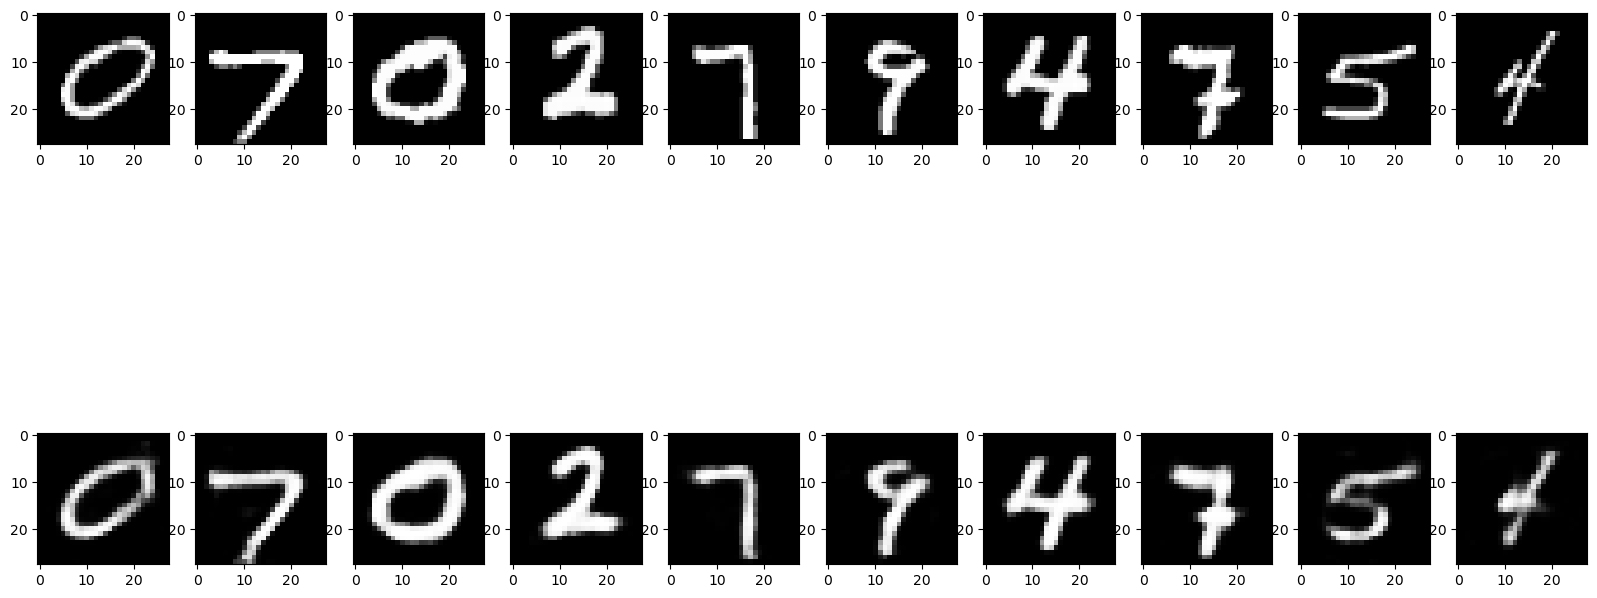

In [25]:
check_example_images(m, test_subset, noise=False)


Co było całkowicie spodziewane, zmniejszenie wymiaru kodu zmniejszyło szczegółowość rekonstrukcji - nie są tak ostre i wyraźne. Mimo to w zdecydowanej większości przypadków kod zmniejszony o połowę sprawdza się wciąż bardzo dobrze - mimo 24-krotnej kompresji cyfry są odwzorowywane dość wiernie. Nadal zachowane jest wiele indywidualnych cech, co widać przy porównaniu różnych obrazów przedstawiających tą samą cyfrę. 

## Ciąg dalszy nastąpi... - Sparse autoencoders

Sparse ("rzadki") autoenkoder jest wykorzystywany w nieco innym celu niż wyżej pokazane autoenkodery. Zazwyczaj wykorzystuje się go, aby nauczyć się istotnych cech danych, które następnie zostaną wykorzystane jako wejście do innego zadania uczenia maszynowego - tym razem już nadzorowanego (np. do klasyfikacji). Do funkcji straty dodaje dodatkowy składnik - karę za brak "rzadkości" w reprezentacji. Funkcja straty wygląda więc następująco: $$L = MSE(x, r(x)) + \Omega(h) $$
gdzie:
- h: wewnętrzna reprezentacja
- $\Omega$: funkcja penalizująca nadmierną gęstość reprezentacji

Im więcej różnych elementów reprezentacji h jest istotnie różne od 0, tym większa będzie wartość funkcji $\Omega(h)$. **To oznacza, że mimo potencjalnie dużej liczby wymiarów reprezentacji h, enkoder jest zachęcany do wykorzystywania jak najmniejszej liczby z nich na raz do opisania jednego wejścia x**.

Zmusza to autoenkoder do reagowania na unikalne cechy statystyczne analizowanych danych i uniemożliwia mu działanie jak zwykła funkcja tożsamościowa.


## Ciąg dalszy nastąpi... - Variatonal autoencoders